In [39]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr,shapiro,f_oneway, ranksums
from scipy.special import stdtr
import csv
import pandas as pd

from scipy.integrate import quad
import sys 
import os
#sys.path.append(os.path.abspath("/Users/neuroimaging/Desktop/MR-code/Python_Code"))

#from ML_UsefulFunctions import *
#from KidneyROIAnalyses import *

from scipy import special

from scipy.integrate import tplquad

pd.options.display.float_format = '{:.3f}'.format


from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.simplefilter("ignore")


from EllipsoidalSimulationCode import *

from sklearn.metrics import r2_score

from statistics import mean

def func(x,m,b):
    return m*x + b

def biexp_func(b, frac_fast,frac_slow,diff_fast,diff_slow):
    Data = frac_slow*np.exp(-b*diff_slow)+frac_fast*np.exp(-b*diff_fast)
    normal = frac_slow+frac_fast
    return Data/normal

In [9]:
fileloc = '/Users/miraliu/Desktop/PostDocCode/Multiexp_Simulations_python/MultiExpSimulatedCurves_20240611.xlsx'
df_True = pd.read_excel(fileloc,sheet_name = 'TrueData') 

df_TrueParams = pd.read_excel(fileloc,sheet_name = 'Parameters') 
df_AveragedNoise = pd.read_excel(fileloc,sheet_name = 'AveragedNoise') 
#Truth=Truth.rename(columns={c: 'True '+c for c in Truth.columns if c not in ['Run Number', 'Unnamed']})

b_values11 = np.array([0,10,30,50,80,120,200,400,800])#, 1100, 1380]) # medium range 11 b values 0 - 1380


In [10]:
# trying tri-exp fit to the df_True
TrueFracs = []
TrueDiffs = []
FitFracs = []
FitDiffs = []
for j in range(500):
    popt, pcov = curve_fit(biexp_func, b_values11,df_True.iloc[j,2:-2],p0=[.1,.7, 0.1, 0.001],bounds=(0, [1,1,.1,.1]),maxfev=10000)
    
    ## order popt from fast to slow diffusion
    norm_popt = popt[0]+popt[1]
    idx_sort = popt[2:4].argsort()
    fracs = popt[0:2]/norm_popt
    diffusions = popt[2:4]
    fracs=fracs[idx_sort[::-1]]
    diffusions=diffusions[idx_sort[::-1]]
    #print(*[df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j],df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    
    ## order given true values from fast to slow just in case
    givenfracs = np.array([df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j]])
    givendiffusions = np.array([df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    idx_sort = givendiffusions.argsort()
    givenfracs = givenfracs[idx_sort[::-1]]
    givendiffusions = givendiffusions[idx_sort[::-1]]

    TrueFracs.append(list(givenfracs))
    TrueDiffs.append(list(givendiffusions))
    FitFracs.append(list(fracs))
    FitDiffs.append(list(diffusions))
    

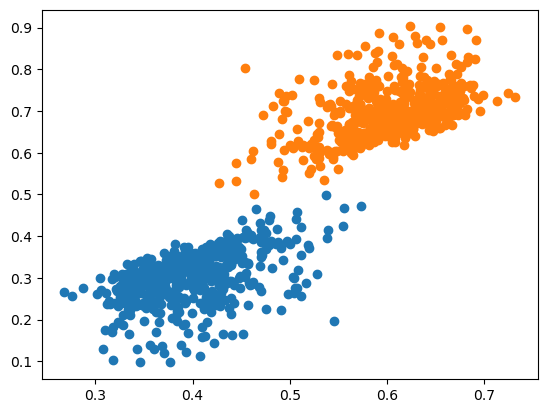

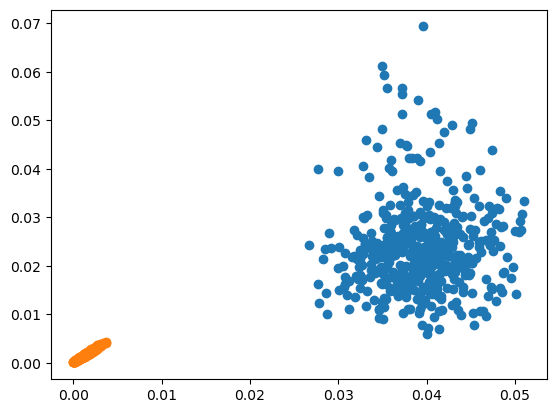

In [17]:

pl.scatter((np.array(TrueFracs)[:,0]+np.array(TrueFracs)[:,1]),np.array(FitFracs)[:,0],label= 'fast frac')

#pl.scatter(np.array(TrueFracs)[:,1],np.array(FitFracs)[:,1], label = 'med frac')
pl.scatter(np.array(TrueFracs)[:,2],np.array(FitFracs)[:,1], label = 'slow frac')
pl.show()

pl.scatter((np.array(TrueDiffs)[:,0]+np.array(TrueDiffs)[:,1])/2,np.array(FitDiffs)[:,0],label= 'fast diffs')
#pl.scatter(np.array(TrueDiffs)[:,1],np.array(FitDiffs)[:,1], label = 'med diffs')
pl.scatter(np.array(TrueDiffs)[:,2],np.array(FitDiffs)[:,1], label = 'slow diffs')
pl.show()




# combined fD isotropic no noise against average tubule + vascular

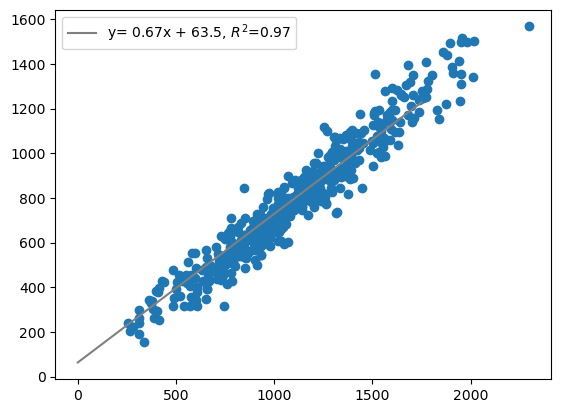

SignificanceResult(statistic=0.9894120054120055, pvalue=0.0)
All fD difference = -136.37540 ± 198.27118, -0.29988%
fast fD mean difference = -2.77362± 1.12467, -28.64989%
slow fD mean difference = 0.34917± 0.26719, 36.52384%


In [24]:
TruefastfDs= (1000*np.array(TrueFracs)[:,0]*np.array(TrueDiffs)[:,0] + 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1])
FitfastfDs = 1000*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0]

#TruemedfDs= 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1]
#FitmedfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

TrueslowfDs= 1000*np.array(TrueFracs)[:,2]*np.array(TrueDiffs)[:,2]
FitslowfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

AllTrue = np.append(TruefastfDs,TrueslowfDs)
AllFit = np.append(FitfastfDs,FitslowfDs)

pl.scatter(112.5*TruefastfDs,112.5*FitfastfDs)
x = np.linspace(0,1750,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(112.5*AllTrue, 112.5*AllFit)
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.show()


print(scipy.stats.spearmanr(112.5*AllTrue, 112.5*AllFit))
print(f'All fD difference = {np.mean(112.5*AllFit - 112.5*AllTrue):.5f} ± {np.std(112.5*AllFit - 112.5*AllTrue):.5f}, {100*np.median((112.5*AllFit - 112.5*AllTrue)/112.5*AllTrue):.5f}%')
print(f'fast fD mean difference = {np.mean(FitfastfDs-TruefastfDs):.5f}± {np.std(FitfastfDs-TruefastfDs):.5f}, {100*np.median((FitfastfDs-TruefastfDs)/TruefastfDs):.5f}%')
#print(f'med fD mean difference = {np.mean(FitmedfDs-TruemedfDs):.5f}± {np.std(FitmedfDs-TruemedfDs):.5f}, {100*np.median((FitmedfDs-TruemedfDs)/TruemedfDs):.5f}%')
print(f'slow fD mean difference = {np.mean(FitslowfDs-TrueslowfDs):.5f}± {np.std(FitslowfDs-TrueslowfDs):.5f}, {100*np.median((FitslowfDs-TrueslowfDs)/TrueslowfDs):.5f}%')


# now with anisotropy and noise

In [45]:
# trying bi-exp fit to the df_True
TrueFracs = []
TrueDiffs = []
FitFracs = []
FitDiffs = []
r2_fit = []
for j in range(500):
    popt, pcov = curve_fit(biexp_func, b_values11,df_AveragedNoise.iloc[j,2:-2],p0=[.1,.7, 0.1, 0.001],bounds=(0, [1,1,.1,.1]),maxfev=10000)
    
    ## order popt from fast to slow diffusion
    norm_popt = popt[0]+popt[1]
    idx_sort = popt[2:4].argsort()
    fracs = popt[0:2]/norm_popt
    diffusions = popt[2:4]
    fracs=fracs[idx_sort[::-1]]
    diffusions=diffusions[idx_sort[::-1]]
    #print(*[df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j],df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    
    ## order given true values from fast to slow just in case
    givenfracs = np.array([df_TrueParams['true fast fraction'].iloc[j],df_TrueParams['true med fraction'].iloc[j],df_TrueParams['true slow fraction'].iloc[j]])
    givendiffusions = np.array([df_TrueParams['true fast diffusion'].iloc[j],df_TrueParams['true med diffusion'].iloc[j],df_TrueParams['true slow diffusion'].iloc[j]])
    idx_sort = givendiffusions.argsort()
    givenfracs = givenfracs[idx_sort[::-1]]
    givendiffusions = givendiffusions[idx_sort[::-1]]

    TrueFracs.append(list(givenfracs))
    TrueDiffs.append(list(givendiffusions))
    FitFracs.append(list(fracs))
    FitDiffs.append(list(diffusions))
    
    y_pred = biexp_func(b_values11, *popt)
    r2_goodness = r2_score(df_AveragedNoise.iloc[j,2:-2], y_pred)
    r2_fit.append(r2_goodness)
    
print(f'goodness of fit: r2={np.mean(r2_fit):.5f}±{np.std(r2_fit):.5f}') 


goodness of fit: r2=0.99565±0.00307


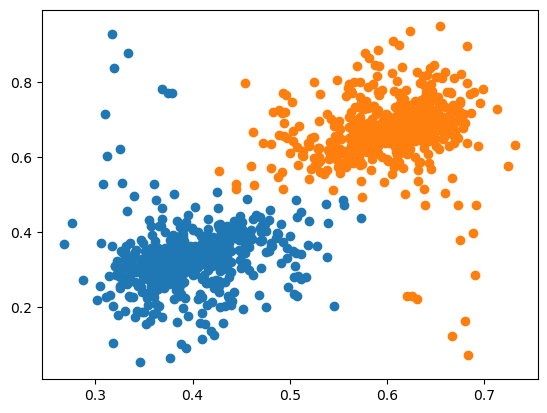

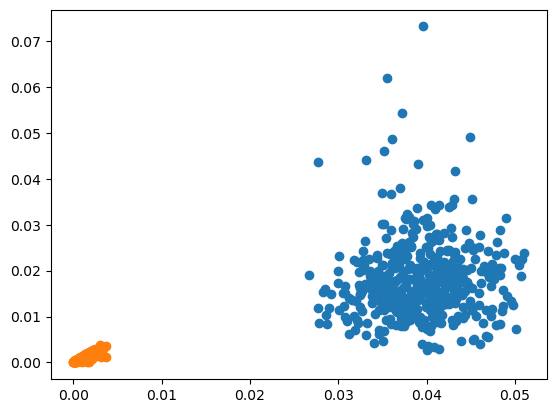

In [27]:

pl.scatter((np.array(TrueFracs)[:,0]+np.array(TrueFracs)[:,1]),np.array(FitFracs)[:,0],label= 'fast frac')

#pl.scatter(np.array(TrueFracs)[:,1],np.array(FitFracs)[:,1], label = 'med frac')
pl.scatter(np.array(TrueFracs)[:,2],np.array(FitFracs)[:,1], label = 'slow frac')
pl.show()

pl.scatter((np.array(TrueDiffs)[:,0]+np.array(TrueDiffs)[:,1])/2,np.array(FitDiffs)[:,0],label= 'fast diffs')
#pl.scatter(np.array(TrueDiffs)[:,1],np.array(FitDiffs)[:,1], label = 'med diffs')
pl.scatter(np.array(TrueDiffs)[:,2],np.array(FitDiffs)[:,1], label = 'slow diffs')
pl.show()


# now combined fD

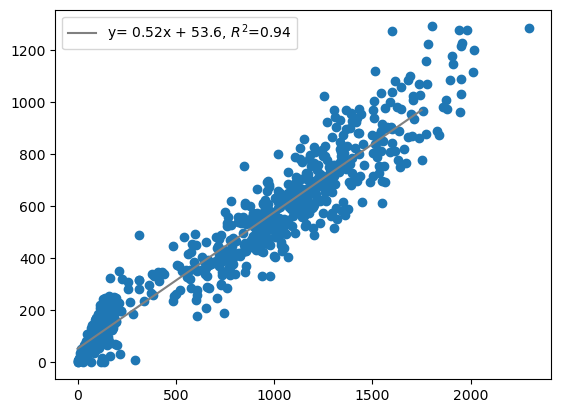

SignificanceResult(statistic=0.9668958188958189, pvalue=0.0)
All fD difference = -231.22527 ± 279.05539, -111.15372%
fast fD mean difference = -4.20799± 1.71159, -43.74954%
slow fD mean difference = 0.09732± 0.32912, 13.64754%


In [35]:
TruefastfDs= (1000*np.array(TrueFracs)[:,0]*np.array(TrueDiffs)[:,0] + 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1])
FitfastfDs = 1000*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0]

#TruemedfDs= 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1]
#FitmedfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

TrueslowfDs= 1000*np.array(TrueFracs)[:,2]*np.array(TrueDiffs)[:,2]
FitslowfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

AllTrue = np.append(TruefastfDs,TrueslowfDs)
AllFit = np.append(FitfastfDs,FitslowfDs)

pl.scatter(112.5*AllTrue,112.5*AllFit)
x = np.linspace(0,1750,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(112.5*AllTrue, 112.5*AllFit)
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.show()


print(scipy.stats.spearmanr(112.5*AllTrue, 112.5*AllFit))
print(f'All fD difference = {np.mean(112.5*AllFit - 112.5*AllTrue):.5f} ± {np.std(112.5*AllFit - 112.5*AllTrue):.5f}, {100*np.median((112.5*AllFit - 112.5*AllTrue)/112.5*AllTrue):.5f}%')
print(f'fast fD mean difference = {np.mean(FitfastfDs-TruefastfDs):.5f}± {np.std(FitfastfDs-TruefastfDs):.5f}, {100*np.median((FitfastfDs-TruefastfDs)/TruefastfDs):.5f}%')
#print(f'med fD mean difference = {np.mean(FitmedfDs-TruemedfDs):.5f}± {np.std(FitmedfDs-TruemedfDs):.5f}, {100*np.median((FitmedfDs-TruemedfDs)/TruemedfDs):.5f}%')
print(f'slow fD mean difference = {np.mean(FitslowfDs-TrueslowfDs):.5f}± {np.std(FitslowfDs-TrueslowfDs):.5f}, {100*np.median((FitslowfDs-TrueslowfDs)/TrueslowfDs):.5f}%')


# fD and compared to just vascular

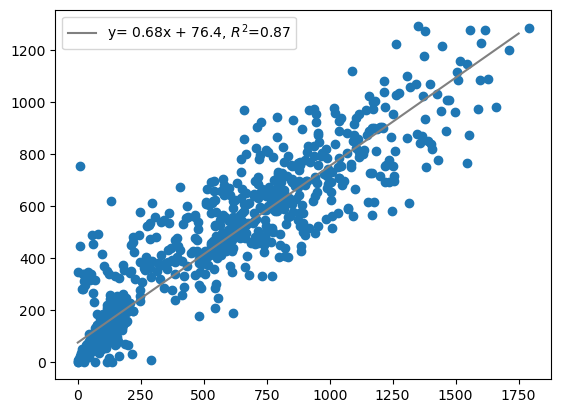

SignificanceResult(statistic=0.9239046119046119, pvalue=0.0)
All fD difference = -61.06675 ± 174.41178, -1.01520%
fast fD mean difference = -1.18295± 1.96956, -18.17307%
slow fD mean difference = 0.09732± 0.32912, 13.64754%


In [46]:
TruefastfDs= (1000*np.array(TrueFracs)[:,0]*np.array(TrueDiffs)[:,0]) #+ 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1])
FitfastfDs = 1000*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0]

#TruemedfDs= 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1]
#FitmedfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

TrueslowfDs= 1000*np.array(TrueFracs)[:,2]*np.array(TrueDiffs)[:,2]
FitslowfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

AllTrue = np.append(TruefastfDs,TrueslowfDs)
AllFit = np.append(FitfastfDs,FitslowfDs)

pl.scatter(112.5*AllTrue,112.5*AllFit)
x = np.linspace(0,1750,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(112.5*AllTrue, 112.5*AllFit)
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.show()


print(scipy.stats.spearmanr(112.5*AllTrue, 112.5*AllFit))
print(f'All fD difference = {np.mean(112.5*AllFit - 112.5*AllTrue):.5f} ± {np.std(112.5*AllFit - 112.5*AllTrue):.5f}, {100*np.median((112.5*AllFit - 112.5*AllTrue)/112.5*AllTrue):.5f}%')
print(f'fast fD mean difference = {np.mean(FitfastfDs-TruefastfDs):.5f}± {np.std(FitfastfDs-TruefastfDs):.5f}, {100*np.median((FitfastfDs-TruefastfDs)/TruefastfDs):.5f}%')
#print(f'med fD mean difference = {np.mean(FitmedfDs-TruemedfDs):.5f}± {np.std(FitmedfDs-TruemedfDs):.5f}, {100*np.median((FitmedfDs-TruemedfDs)/TruemedfDs):.5f}%')
print(f'slow fD mean difference = {np.mean(FitslowfDs-TrueslowfDs):.5f}± {np.std(FitslowfDs-TrueslowfDs):.5f}, {100*np.median((FitslowfDs-TrueslowfDs)/TrueslowfDs):.5f}%')


# bi-exp fD and compared to just tubule

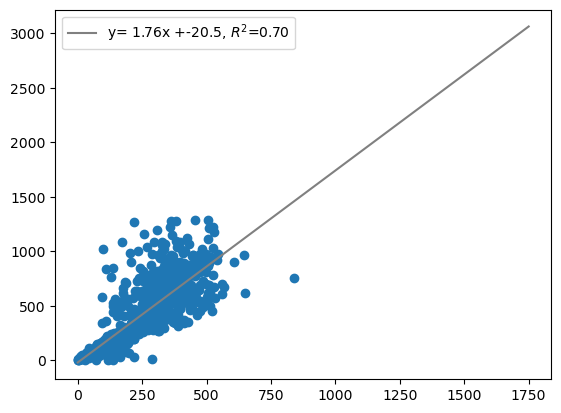

SignificanceResult(statistic=0.8946763026763028, pvalue=0.0)
All fD difference = 146.64299 ± 199.99538, 63.53164%
fast fD mean difference = 2.50967± 1.81732, 74.67780%
slow fD mean difference = 0.09732± 0.32912, 13.64754%


In [37]:
TruefastfDs= (1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1])
FitfastfDs = 1000*np.array(FitFracs)[:,0]*np.array(FitDiffs)[:,0]

#TruemedfDs= 1000*np.array(TrueFracs)[:,1]*np.array(TrueDiffs)[:,1]
#FitmedfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

TrueslowfDs= 1000*np.array(TrueFracs)[:,2]*np.array(TrueDiffs)[:,2]
FitslowfDs = 1000*np.array(FitFracs)[:,1]*np.array(FitDiffs)[:,1]

AllTrue = np.append(TruefastfDs,TrueslowfDs)
AllFit = np.append(FitfastfDs,FitslowfDs)

pl.scatter(112.5*AllTrue,112.5*AllFit)
x = np.linspace(0,1750,100)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(112.5*AllTrue, 112.5*AllFit)
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.show()


print(scipy.stats.spearmanr(112.5*AllTrue, 112.5*AllFit))
print(f'All fD difference = {np.mean(112.5*AllFit - 112.5*AllTrue):.5f} ± {np.std(112.5*AllFit - 112.5*AllTrue):.5f}, {100*np.median((112.5*AllFit - 112.5*AllTrue)/112.5*AllTrue):.5f}%')
print(f'fast fD mean difference = {np.mean(FitfastfDs-TruefastfDs):.5f}± {np.std(FitfastfDs-TruefastfDs):.5f}, {100*np.median((FitfastfDs-TruefastfDs)/TruefastfDs):.5f}%')
#print(f'med fD mean difference = {np.mean(FitmedfDs-TruemedfDs):.5f}± {np.std(FitmedfDs-TruemedfDs):.5f}, {100*np.median((FitmedfDs-TruemedfDs)/TruemedfDs):.5f}%')
print(f'slow fD mean difference = {np.mean(FitslowfDs-TrueslowfDs):.5f}± {np.std(FitslowfDs-TrueslowfDs):.5f}, {100*np.median((FitslowfDs-TrueslowfDs)/TrueslowfDs):.5f}%')
